In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Unsupervised Learning Task

Now that we developed a predictive model for salary, there is additional analysis that I wanted to try with unsupervised learning techniques.

There is one thing that I wanted to look at in particular, positions.
Here is a plot that shows salaries by position for the 2016-2017 NBA season.

<img src="other_assets/sal_position.png" width="450">

Developing our supervised learning model made me curious about this because we were able to determine points, rebounds and assists to be the features with the highest explanatory power in predicting salary. And though centers (who have the highest average salary) usually have the highest number of rebounds, the other positions such as shooting guard and point guard usually accumulate the most points.

This made me think perhaps these positions aren't descriptive of how a particular actually plays. On paper, they might be designated and given a single position but when they actually play, they are a different position or a mixture of these positions together.

So I am going to use unsupervised techniques to re-define the NBA positions - to 5 new clusters. The clusters are going to be developed based on their on-court statistics and grouping them together into new defined positions called clusters.

# Data Cleaning

The same data cleaning steps that we used for the salary prediction model are used below. The only difference is that instead of points, we are going to keep 2pts and 3pts and get rid of the pts column. 2pts and 3pts together add up to points but we are making this change because whether a player makes more three pointers than they do 2 pointers can determine a particular player's style of play and it can provide insight to how best to redefine their position.

In [2]:
!pip install psycopg2

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor

def execute_query(query):  
    connection = pg2.connect(host='postgres',
                             user='postgres',
                             database='basketball')
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    cursor.execute(query)
    r = cursor.fetchall()
    cursor.close()
    return r

def query_to_df(query):
    df = pd.DataFrame(execute_query(query))
    return df

In [209]:
nba_df = query_to_df('SELECT * FROM nba_2016')
nba_df.head()

,age,all_star,ast,blk,college,draft_position,draft_year,drb,efg_perc,fg,...,three_att,three_p,three_perc,tov,trb,two_att,two_p,two_perc,weight_lbs,ws
0,24,0,4.0,13.0,Purdue University,46,2016,28.0,0.464,17.0,...,10.0,5.0,0.500,10.0,36.0,32.0,12.0,0.375,260.0,0.0
1,32,0,125.0,9.0,University of Oregon,26,2007,51.0,0.483,121.0,...,128.0,48.0,0.375,66.0,69.0,172.0,73.0,0.424,161.0,0.3
2,21,0,150.0,40.0,University of Arizona,4,2014,289.0,0.499,393.0,...,267.0,77.0,0.288,89.0,405.0,598.0,316.0,0.528,220.0,3.7
3,22,0,3.0,0.0,University of Kentucky,0,0,3.0,0.000,0.0,...,2.0,0.0,0.000,0.0,3.0,2.0,0.0,0.000,210.0,0.1
4,25,0,7.0,7.0,Michigan State University,15,2014,24.0,0.454,23.0,...,15.0,3.0,0.200,8.0,33.0,39.0,20.0,0.513,237.0,0.2


Keeping stats like height and inches as it helps us differentiate positions.

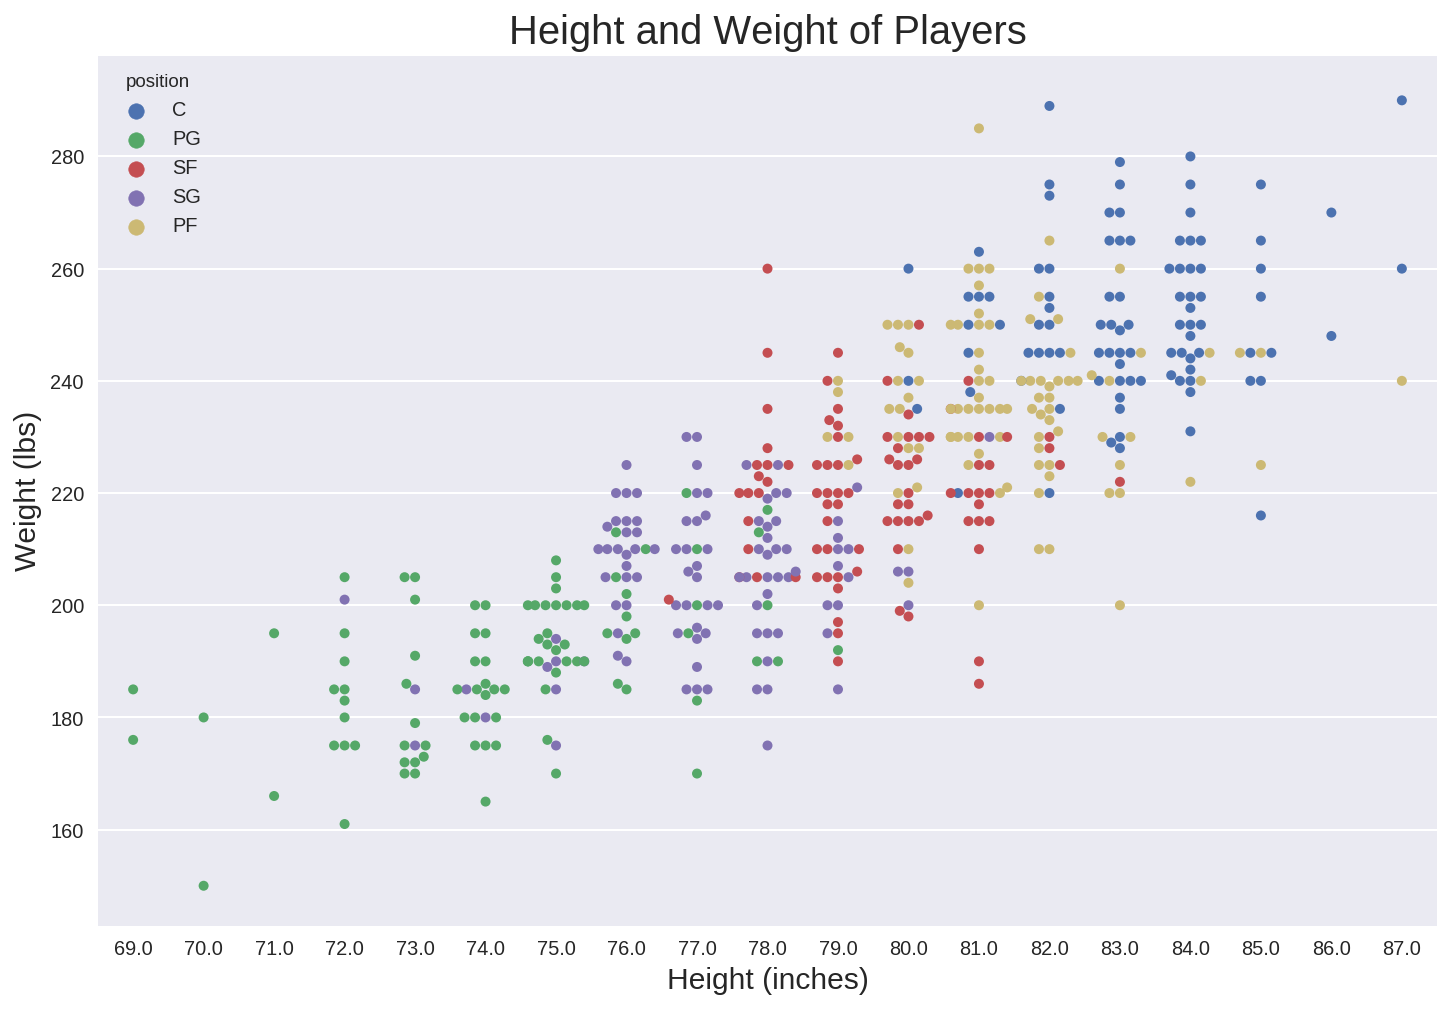

In [210]:
fig = plt.figure(figsize=(12,8)) 
ax = plt.gca()

sns.swarmplot(x="height_inches", y="weight_lbs", hue="position", data=nba_df)

ax.set_title('Height and Weight of Players',size=20)
ax.set_ylabel('Weight (lbs)', fontsize=15)
ax.set_xlabel('Height (inches)', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

Going to remove players who didn't get very much playing time as it's going to be difficult to incorporate them into clusters if they have little to no playing time and recorded statistics. There are some players who don't have any statistics recorded at all.

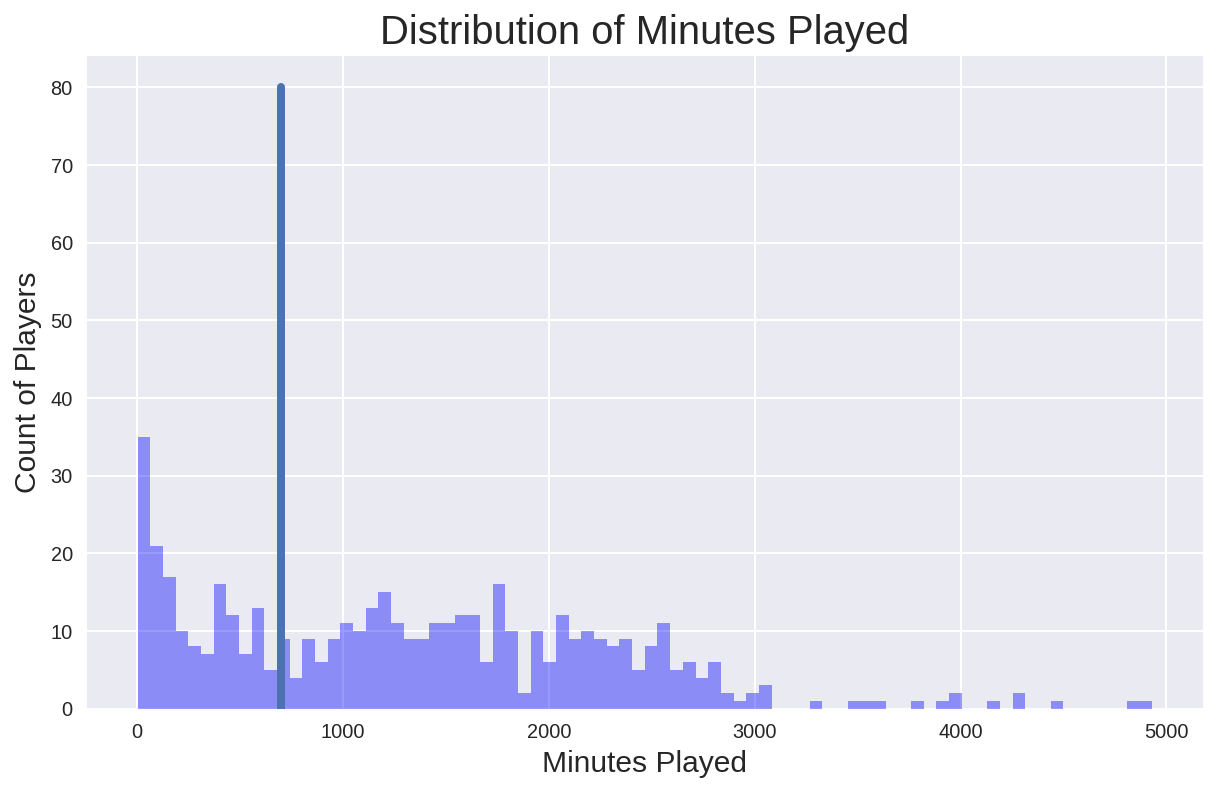

In [214]:
fig = plt.figure(figsize=(10,6)) 
ax = plt.gca()

sns.distplot(nba_df['mp'], kde=False, color="b",bins=80)

ax.set_title('Distribution of Minutes Played',size=20)
ax.set_ylabel('Count of Players', fontsize=15)
ax.set_xlabel('Minutes Played', fontsize=15)
plt.plot([700, 700], [80, 0], linewidth=4)
plt.show()

Based on the plot above going to remove players who played less than 700 minutes.

In [188]:
nba_df = nba_df[nba_df['mp'] > 750]

##### Drop these fields
- Shooting_Hand
- College
- Draft_Year
- Draft_Position
- All_star
- PER
- WS
- Salary
- Age
- Season Count

The list is slightly different from the one of our predictive model as there are some fields that go into a player's position - such as height and weight.

And also getting rid of statistics like Win-Shares as it doesn't relate at all to redefining position

In [189]:
nba_df.drop(['shooting_hand','college','draft_year','draft_position','all_star','per','ws','salary','age','season_count','tov'],axis=1, inplace=True)

#### Excluding rookies
##### Drop these rows
- Any rookies which mean any rows that have a player with a season count lower than 3
    - 172 rookies
    - 486 total players
    - 314 players in our final data set
    
##### Drop these fields
- Age
- Season_count

In [190]:
#nba_df = nba_df[nba_df['season_count'] > 3]

In [191]:
#nba_df.drop(['age','season_count'],axis=1,inplace=True)

#### Per Game Statistics
##### Adjust these fields to per game
- FG: Field Goals
- FGA: Field Goal Attempts 
- Three_P: 3-Point Field Goals 
- Three_Att: 3-Point Field Goal Attempts 
- Two_P: 2-Point Field Goals 
- Two_Att: 2-Point Field Goal Attempts 
- FT: Free Throws 
- FTA: Free Throw Attempts 
- ORB: Offensive Rebounds 
- DRB: Defensive Rebounds 
- TRB: Total Rebounds 
- AST: Assists 
- STL: Steals 
- BLK: Blocks 
- TOV: Turnovers 
- PF: Personal Fouls 
- PTS: Points 

##### Drop these fields
- G: Games
- GS: Games Start
- MP: Minutes Played

In [192]:
adjust_columns = [
    'fg',
    'fga',
    'three_p',
    'three_att',
    'two_p',
    'two_att',
    'ft',
    'fta',
    'orb',
    'drb',
    'trb',
    'ast',
    'stl',
    'blk',
    'pf',
    'pts'
]

In [193]:
for column in adjust_columns:
    nba_df[column] = nba_df[column] / nba_df['g']

In [194]:
nba_df.drop(['g','gs','mp'],axis=1,inplace=True)

#### Dropping columns that have high correlation with others

The features (stats) in our data set need to be independent from one another. From our EDA and our heatmap diagram, we noticed that there are stats columns that are highly (or even directly) correlated with one another. This will affect our model as it'll be unevenly weighting certain statistics and not others because it's appearing more than once in any given column. For example, field goals, field goal attempts and field goal percentage are directly correlated with one another. So we could take out 2 of those 3 statistics.

From the heatmap above, we could identify the stats columns that are highly correlated with one another and drop those columns. Going to  So we are going to drop the following.

- fg
- fga
- fg_percent
- three_att
- three_perc
- two_att
- two_perc
- fta
- orb
- drb
- ft 
- pts 

In [195]:
nba_df.drop(['fg','fga','fg_perc','three_att','two_att','fta','orb','drb','three_perc','two_perc','ft','pts'],axis=1,inplace=True)

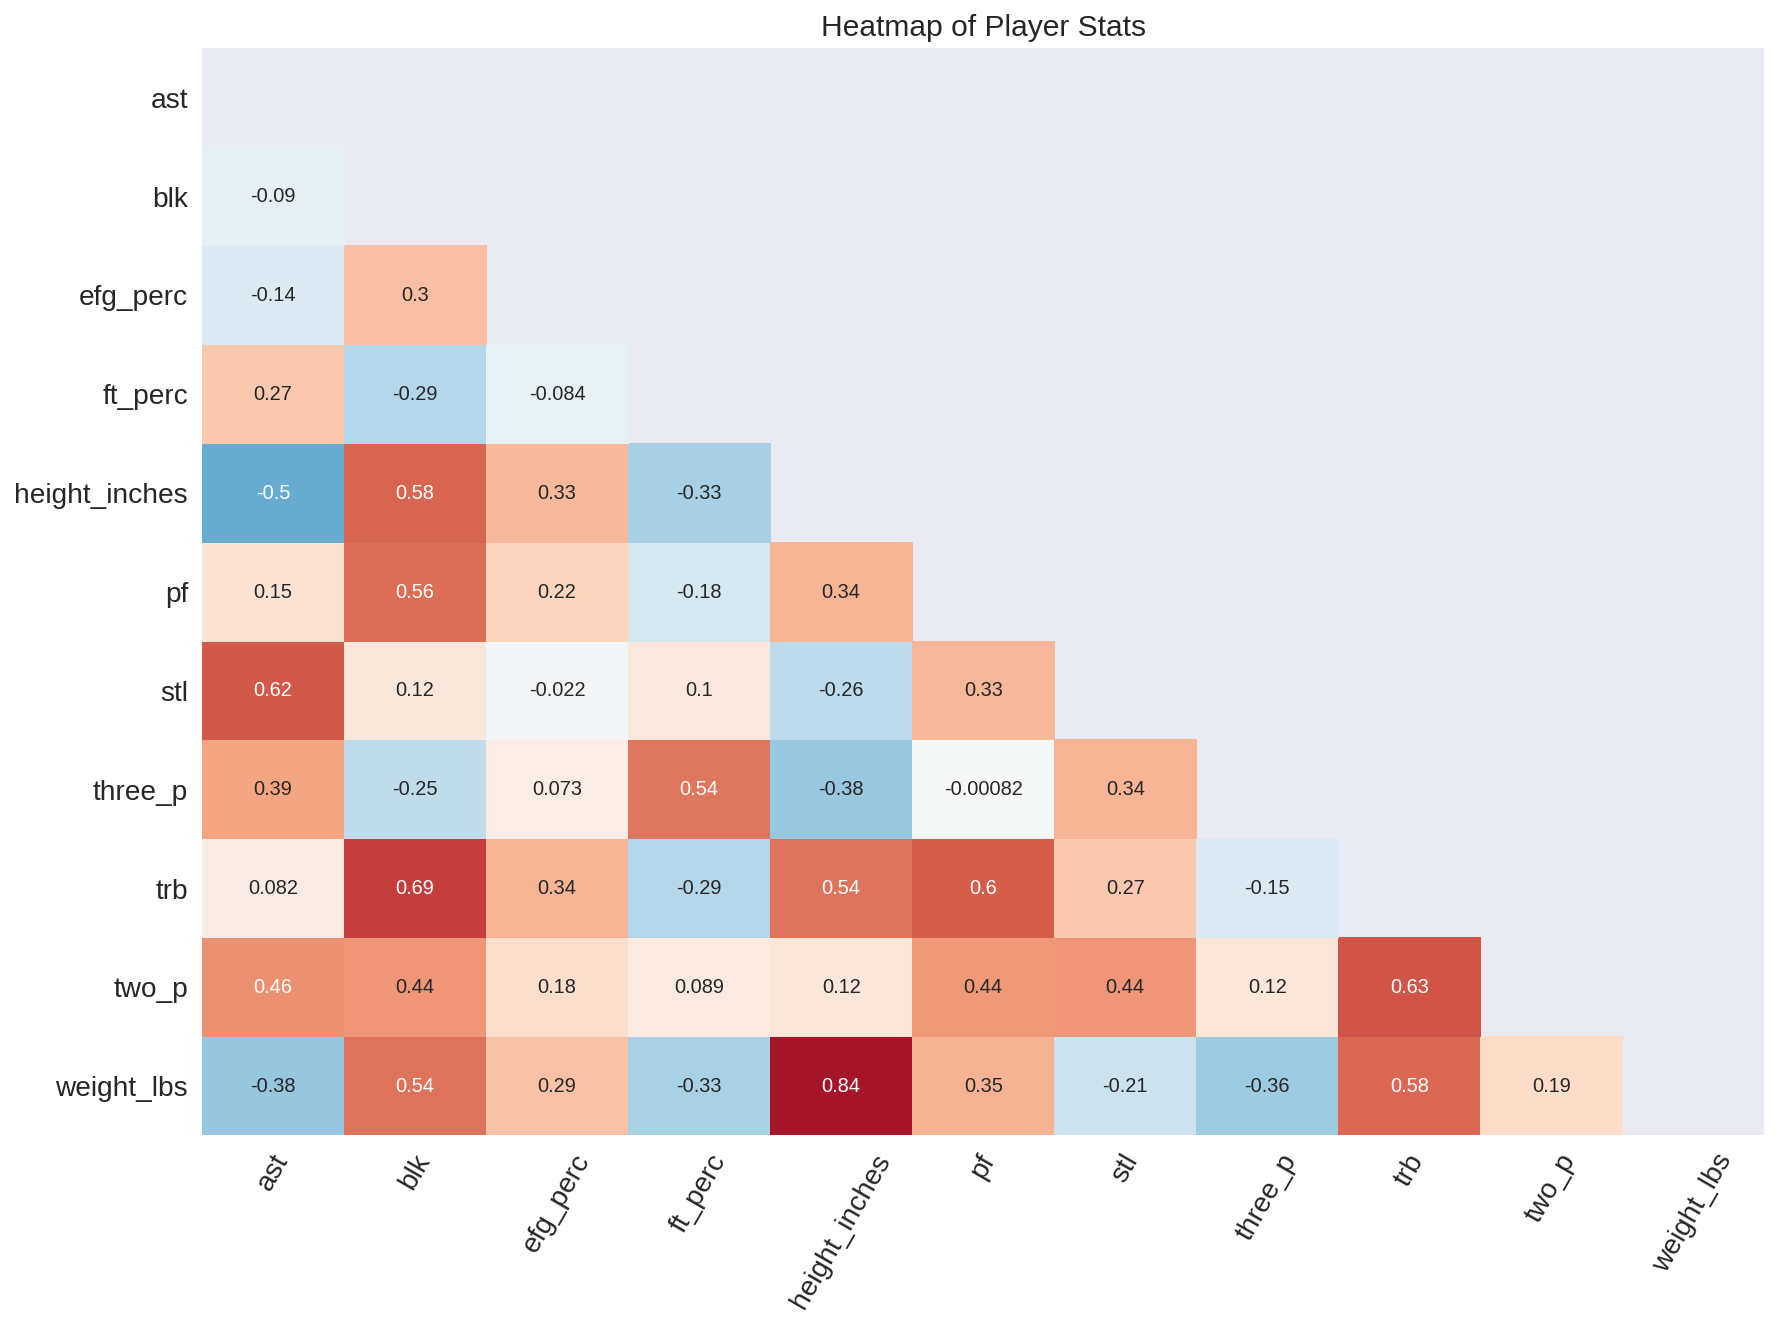

In [196]:
corrs = nba_df.corr()

fig, ax = plt.subplots(figsize = (14, 10))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=60)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
ax.set_title("Heatmap of Player Stats", size=15)

plt.show()

#### Fill null values

In [197]:
nba_df.fillna(0,inplace=True)

#### Our final data set

Here is a final look at our data set.

In [198]:
from sklearn.externals import joblib

In [199]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 1 to 485
Data columns (total 13 columns):
ast              326 non-null float64
blk              326 non-null float64
efg_perc         326 non-null float64
ft_perc          326 non-null float64
height_inches    326 non-null float64
pf               326 non-null float64
player           326 non-null object
position         326 non-null object
stl              326 non-null float64
three_p          326 non-null float64
trb              326 non-null float64
two_p            326 non-null float64
weight_lbs       326 non-null float64
dtypes: float64(11), object(2)
memory usage: 35.7+ KB


In [200]:
joblib.dump(nba_df,'pickled_files/nba_df_unsupervised')

['pickled_files/nba_df_unsupervised']

# K-Means Clustering

In [201]:
nba_u = nba_df.drop(['player','position'],axis=1)
nba_u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 1 to 485
Data columns (total 11 columns):
ast              326 non-null float64
blk              326 non-null float64
efg_perc         326 non-null float64
ft_perc          326 non-null float64
height_inches    326 non-null float64
pf               326 non-null float64
stl              326 non-null float64
three_p          326 non-null float64
trb              326 non-null float64
two_p            326 non-null float64
weight_lbs       326 non-null float64
dtypes: float64(11)
memory usage: 30.6 KB


In [202]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [203]:
ss = StandardScaler()
nba_u_scaled = ss.fit_transform(nba_u)

In [204]:
km = k_means(nba_u_scaled, n_clusters=5)

In [205]:
km[1]

array([2, 4, 3, 1, 4, 2, 1, 4, 1, 3, 4, 1, 1, 2, 0, 3, 2, 4, 4, 2, 2, 0, 2,
       1, 3, 4, 4, 4, 0, 4, 2, 2, 4, 3, 2, 0, 4, 2, 2, 4, 3, 4, 0, 1, 1, 2,
       2, 2, 1, 2, 0, 0, 4, 4, 4, 2, 4, 2, 1, 4, 4, 1, 2, 0, 3, 4, 0, 4, 2,
       1, 2, 4, 0, 2, 1, 0, 4, 4, 4, 4, 3, 1, 4, 0, 2, 1, 0, 2, 1, 0, 0, 4,
       0, 4, 4, 0, 0, 0, 2, 3, 4, 0, 0, 3, 1, 4, 3, 4, 2, 4, 0, 2, 2, 2, 2,
       4, 3, 0, 1, 2, 2, 2, 4, 0, 3, 1, 4, 1, 2, 4, 4, 0, 4, 2, 0, 2, 0, 1,
       4, 4, 4, 3, 4, 1, 0, 4, 4, 1, 2, 0, 2, 0, 0, 4, 3, 4, 4, 2, 1, 2, 3,
       0, 1, 4, 0, 1, 0, 0, 3, 3, 0, 0, 1, 2, 3, 4, 4, 0, 1, 0, 3, 4, 2, 1,
       4, 2, 3, 2, 4, 1, 4, 4, 0, 2, 2, 3, 1, 2, 4, 0, 4, 3, 1, 4, 4, 1, 4,
       2, 1, 4, 4, 2, 1, 0, 4, 4, 4, 4, 4, 2, 1, 3, 4, 1, 1, 4, 0, 2, 3, 4,
       3, 1, 2, 4, 0, 4, 4, 0, 2, 4, 2, 1, 0, 3, 4, 4, 0, 2, 2, 2, 0, 4, 1,
       0, 0, 1, 4, 2, 2, 4, 1, 3, 3, 0, 4, 1, 4, 2, 2, 3, 2, 0, 4, 2, 2, 4,
       2, 4, 4, 0, 1, 0, 3, 1, 1, 4, 4, 4, 2, 4, 1, 2, 2, 1, 2, 4, 0, 2, 4,
       0, 1,

In [206]:
silhouette_score(nba_u_scaled, km[1])

0.15245120218048649

In [207]:
nba_df['new_position'] = km[1]

In [208]:
nba_df[nba_df['player'] == 'Kevin Durant']

,ast,blk,efg_perc,ft_perc,height_inches,pf,player,position,stl,three_p,trb,two_p,weight_lbs,new_position
267,4.83871,1.596774,0.594,0.875,81.0,1.887097,Kevin Durant,SF,1.064516,1.887097,8.274194,7.0,240.0,3


In [75]:
# Repeat the same as above on scaled data.
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('km',KMeans(n_clusters=5))
])

# 1. Run K-Means 
pipe.fit(nba_u)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('km', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [76]:
# 2. Assign clusters back to our dataframe
predicted = pipe.steps[1][1].labels_
nba_df['new_position'] = predicted
nba_df.head()

,ast,blk,efg_perc,ft_perc,height_inches,pf,player,position,stl,three_p,trb,two_p,weight_lbs,new_position
1,1.923077,0.138462,0.483,0.800,72.0,1.430769,Aaron Brooks,PG,0.384615,0.738462,1.061538,1.123077,161.0,1
2,1.875000,0.500000,0.499,0.719,81.0,2.150000,Aaron Gordon,SF,0.812500,0.962500,5.062500,3.950000,220.0,0
5,4.955882,1.264706,0.527,0.800,82.0,2.029412,Al Horford,C,0.764706,1.264706,6.838235,4.308824,245.0,4
6,0.863636,0.242424,0.499,0.765,82.0,1.893939,Al Jefferson,C,0.287879,0.000000,4.212121,3.560606,289.0,2
7,1.622951,0.721311,0.468,0.706,81.0,1.672131,Al-Farouq Aminu,SF,0.983607,1.147541,7.393443,1.852459,220.0,0


In [34]:
ss = StandardScaler()
nba_u_scaled = ss.fit_transform(nba_u)

In [77]:
silhouette_score(nba_u, predicted)

0.0080767064159567806

In [39]:
silhouette_score(centroids, predicted)

ValueError: Found input variables with inconsistent numbers of samples: [5, 332]

In [38]:
#3 Get our centroids
centroids = pipe.steps[1][1].cluster_centers_
centroids = pd.DataFrame(centroids,columns=nba_u.columns)
centroids.head()

,ast,blk,efg_perc,ft_perc,height_inches,pf,stl,three_p,tov,trb,two_p,weight_lbs
0,1.588614,-0.213689,-0.084517,0.620810,-0.795852,0.441753,1.345924,1.072242,1.528710,0.150187,1.090272,-0.649962
1,-0.566213,-0.293577,-0.082639,-0.034719,0.358673,-0.454530,-0.417231,0.027940,-0.656055,-0.316118,-0.633892,0.217693
2,0.132632,-0.643019,-0.510994,0.396444,-0.994027,-0.600510,-0.170494,0.113403,-0.175936,-0.821247,-0.490428,-0.965856
3,0.226461,2.032848,0.519295,-0.103040,1.091289,1.368177,0.394947,-0.142511,0.973936,1.953300,1.574705,1.223963
4,-0.612096,0.685334,0.716407,-0.982185,0.955648,0.674706,-0.314633,-1.041289,-0.303356,0.717855,0.198139,0.982724


In [ ]:
# 4. Plot the scatter of our points with calculated centroids
colors = ["red", "green", "blue","brown","yellow"]
colormap = [colors[color] for color in nba_df['new_position'].values]
colormap_centroids = [colors[color] for color in centroids.index]